# Label CDK2 conformations

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import pytraj as pyt
import sys
sys.path.append('../..')
%load_ext autoreload
%autoreload 2

### Load the DataFrame with the PDB entries metadata

In [2]:
prot_name = 'cdk2'
file = f'./df_metadata_{prot_name}_pdbids_LIGS.pkl'
df_prot_lig = pd.read_pickle(file)

## Load all the PDB structures as a conformational ensemble
- Load all the conformations (`pdb` files) using `pytraj`

In [3]:
ROOT_DIR = '../../data/crystal_confs/'

# Create a crystallographic ensemble (pseudo trajectory)
ENS_CONFS_DIR = f'{ROOT_DIR}/pdb_ensemble'
input_files = sorted(glob(f'{ENS_CONFS_DIR}/*_ENS.pdb'))

# Make sure the order of conformations in `input_files` 
# and `pdb_ids` is the same
input_files_basenames = [i.split('/')[-1].replace('_ENS.pdb', '') 
                         for i in input_files]
assert np.all(df_prot_lig['PDB_ID'] == input_files_basenames)

In [4]:
# Use `pytraj` to load all conformations
crys_traj = pyt.iterload(input_files, top = input_files[0])
crys_traj

pytraj.TrajectoryIterator, 418 frames: 
Size: 0.045295 (GB)
<Topology: 4848 atoms, 298 residues, 1 mols, non-PBC>
           

## Label PDB Structures

### Conformation types:

| Conformation Type | PDB Entry       |  Criteria |  
| :- |:------------- | :--
|**Active**|<mark style="background-color: #FFBAAD">1fin</mark>| Salt bridge between Lys33-Glu51 | 
|**Inactive** Src-Like|<mark style="background-color: #B0E6EA">4kku</mark>| No Lys33-Glu51 interaction |
|**Inactive** Open|<mark style="background-color: #FAE5BF">3pxf</mark>| $\alpha$C displacement from $\beta_4$ and $\beta_5$ sheets, forming an allosteric binding site |
|**Inactive** DFG-out|<mark style="background-color: #D5BFFA">5a14</mark>| Asp145 and Phe146 flipped |


![CDK2_main_conformations](./CDK2_main_conformations.png "CDK2 Confs.")



### Criteria for label a given CDK2 conformation:

```python
if Lys33-Glu51 salt bridge exists:
    if Asp145 and Phe146 are flipped:
        label = DFG-out
    else:
        label = Active
else:
    if alphaC is displaced:
        label = Open
    else:
        label = Src-like
```

###  Functions to evaluate the above criteria
- The following functions will be used to evaluate each criterion described above. These functions are implemented in the `label_cdk2_confs.py` module, inside `helper_modules`. 

#### Does the `Lys33-Glu51` salt bridge exist?
- Measure the distance between atoms `:33@NZ` and `:51@CD`.
- If the distance is lower than 7.0 Angstroms, the salt bridge exists.
```python
# Evaluates if the salt bridge between LYS33-GLU51 exists
saltbridge_cutoff = 7.0
is_salt_bridge = get_distance_ij(traj_obj, ':33@NZ', ':51@CD') < saltbridge_cutoff
````

#### Are `Asp145` and `Phe146`  Flipped?
- Measures the phi angle at position 145 (Asp145).
- We will use the conformation `5a14` as the reference for this criterion.
    - In the `5a14` DFG-in conformation, the value of the phi angle of ASP is -138.7.
    - We will use -135.0 as the cutoff value.
- If the phi angle at position 145 is lower than -135.0 ASP145 is flipped

```python
dfg_angle_cutoff = -135.0
get_phi_angle(traj_obj, residue = 145) < dfg_angle_cutoff
```


#### Is the $\alpha$C helix displaced from $\beta_4$ and $\beta_5$ sheets?

- Measures the distance between geometric centers of $\alpha$C helix (residues 46 to 57) and the residues belonging to the $\beta_4$ and $\beta_5$ sheets (66-72, 75-81).
    - This residues are mentioned in the UniProt entry of CDK2.
- We will use the conformation `3pxf` as the reference for this criterion.
    - In the `3pxf` conformation (and other conformations including the 2AN ligand) the distance between these atom groups is greater than 15.0 Angstroms.
    - We will use 12.5 Angstroms as the cutoff value.
- If the distance is greater than 12.5 Angstroms, then the conformation is open.

```python
aC_b4b5_dist_cutoff = 12.5
is_aC_displaced = get_geom_center_distance(traj_obj, 
                            ':46-57', ':66-72,75-81') > aC_b4b5_dist_cutoff
```

### Implement the functions to label CDK2 conformations

In [5]:
from helper_modules.label_cdk2_confs import *

In [6]:
%%time
labels = label_cdk2_conformations(traj_obj = crys_traj, 
                         saltbridge_cutoff   = 7.0, 
                         dfg_angle_cutoff    = -135.0,
                         aC_b4b5_dist_cutoff = 12.5)

CPU times: user 1.94 s, sys: 169 ms, total: 2.11 s
Wall time: 2.11 s


In [7]:
df_prot_lig['ConfTypeLabel'] = labels
df_prot_lig['ConfTypeLabel'].value_counts()

inact_src    292
active       120
inact_ope      5
dfg_out        1
Name: ConfTypeLabel, dtype: int64

In [8]:
df_prot_lig.query('ConfTypeLabel == "dfg_out"')

,PDB_ID,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,NonStndResnames,NonStndResnums,LigPktName,LigMW,LigNHeavyAtoms,LigDistToPocket,ConfTypeLabel
351,5a14,type ii inhibitors targeting cdk2.,2015-07-22,1,A,2.0,0.993,95.302,3,"[2, 10, 2]","[[39, 40], [154, 163], [296, 297]]",1,[LQ5],None,None,LQ5,475.29771,36.0,6.435824,dfg_out


In [9]:
### Save the new DataFrame
filename = './df_metadata_cdk2_pdbids_LIGS_CONF-LABELS.pkl'
df_prot_lig.to_pickle(filename)

## Classical Multidimensional Scaling

In [9]:
# Implement mds
from helper_modules.classical_MDS import cMDS
from helper_modules.protein_subsequences import get_pisani_residues

In [10]:
pisani_residues = get_pisani_residues(sep=',')
pisani_mask = f':{pisani_residues}&(@CA)'

In [11]:
pair_rmsd_pisani = pyt.pairwise_rmsd(traj = crys_traj,
                                     mask = pisani_mask, 
                                     metric ='rms')
mds_pisani = cMDS(pair_rmsd_pisani)[0]

In [12]:
def plot_subspace(x, y, title = '', figsize = (8, 8), **kwargs):
    '''A simple scatterplot function'''
    fig, ax = plt.subplots(figsize = figsize)
    sns.scatterplot(x = x, y = y, 
                    linewidth = 0, color = '#02A298',
                    **kwargs
                   )
    ax.set_title(title)
    ax.set(xlabel = 'Dim. 1', ylabel = 'Dim. 2')
    ax.axvline(0, ls = ':', color = 'gray', lw = 2.5)
    ax.axhline(0, ls = ':', color = 'gray', lw = 2.5)
    ax.grid()
    return ax

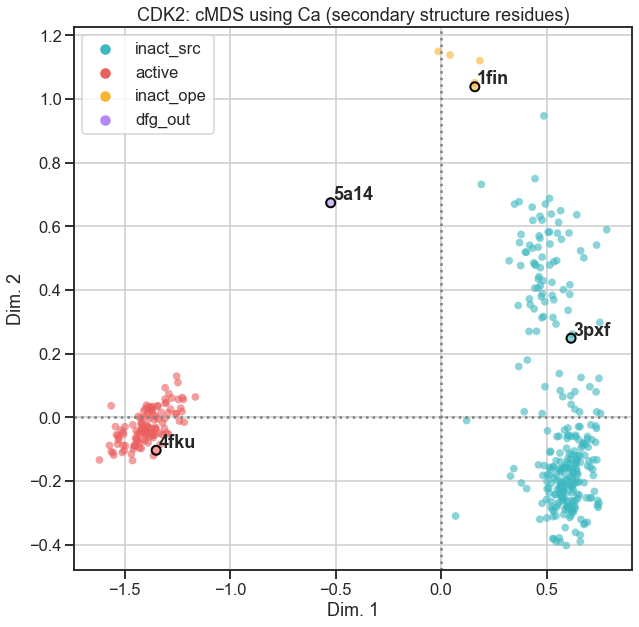

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks', context='talk')

# Highlight the reference structures
ref_confs_names = ['4fku', '1fin', '3pxf', '5a14']
ref_confs_colors = ['#3DB8C1', '#EB5F5F',  '#FAB332', '#B389FA']
df_ref_confs = df_prot_lig.loc[[i in ref_confs_names 
                 for i in df_prot_lig['PDB_ID']]]
df_ref_confs_idxs = df_ref_confs.index

# Plot the first two dims of the cMDS
x, y = mds_pisani[:2]
ax = plot_subspace(x, y, 
    title = 'CDK2: cMDS using Ca (secondary structure residues)',
             hue = df_prot_lig['ConfTypeLabel'],
    s = 60, alpha = 0.6, palette = ref_confs_colors,
    figsize = (10, 10))
# Plot the reference conformations
sns.scatterplot(
    x = x[df_ref_confs_idxs],
    y = y[df_ref_confs_idxs],
    linewidth = 2, edgecolor = 'black',
    facecolors = 'none',
    ax = ax
)
for idx, conf in zip(df_ref_confs_idxs, ref_confs_names):
    plt.text(x[idx] + 0.01, y[idx] + 0.01, 
             s = conf, fontweight = 'bold')

plt.show()